In [3]:
import pandas as pd
import json
import requests
import time
import numpy as np
from functools import reduce
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pickle

import keras as keras
from keras.models import Model
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

## Introduction

The purpose of this notebook is to show the steps for data prepration for the prediction task.

## Data Collection
We get our raw data from Alpha Vantage APIs as it's refined and free of cost.
The data is got in form of JSON object which is stored as a pandas dataframe in a dictionary with symbol name as the key

In [4]:
# commonly used variables

symbol = "AAPL";
apikey = "V1SZPLE0U8CCXSFW.";
datatype = "json";
url = "https://www.alphavantage.co/query";
outputsize = "full";
interval = "daily";
timeperiod = "10";
seriestype = "close";
index = "date";
plt.style.use('seaborn');

In [5]:
# Time Series Data

parameters = {'function':'TIME_SERIES_DAILY_ADJUSTED', 'outputsize':outputsize,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_TS_data = pd.DataFrame(data["Time Series (Daily)"]).T

AAPL_TS_data.reset_index(inplace=True);
AAPL_TS_data.rename(columns={'index': 'date'}, inplace=True);

AAPL_TS_data.rename(columns={'1. open': 'open'}, inplace=True);
AAPL_TS_data.rename(columns={'2. high': 'high'}, inplace=True);
AAPL_TS_data.rename(columns={'3. low': 'low'}, inplace=True);
AAPL_TS_data.rename(columns={'4. close': 'close'}, inplace=True);
AAPL_TS_data.rename(columns={'5. adjusted close': 'adjusted close'}, inplace=True);
AAPL_TS_data.rename(columns={'6. volume': 'volume'}, inplace=True);
AAPL_TS_data.rename(columns={'7. dividend amount': 'dividend amount'}, inplace=True);
AAPL_TS_data.rename(columns={'8. split coefficient': 'split coefficient'}, inplace=True);

# Let's add another column to the frame which is the adjusted close data shifted by 10 days which is what we want to predict

AAPL_TS_data["Target"] = AAPL_TS_data["adjusted close"].shift(-10);

# Now that we donot have the data of the future we need to clip the dataframe where the target is not defined 
AAPL_TS_data = AAPL_TS_data.dropna()


display(AAPL_TS_data.tail())
display(AAPL_TS_data.info())

,date,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Target
5245,2018-11-05,204.3000,204.3900,198.1700,201.5900,200.8866,66163669,0.0000,1.0000,185.8600
5246,2018-11-06,201.9200,204.7200,201.6900,203.7700,203.0590,31882881,0.0000,1.0000,176.9800
5247,2018-11-07,205.9700,210.0600,204.1300,209.9500,209.2175,33424434,0.0000,1.0000,176.7800
5248,2018-11-08,209.9800,210.1200,206.7500,208.4900,208.4900,25362636,0.7300,1.0000,172.2900
5249,2018-11-09,205.5500,206.0100,202.2500,204.4700,204.4700,34365750,0.0000,1.0000,173.6600


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 10 columns):
date                 5250 non-null object
open                 5250 non-null object
high                 5250 non-null object
low                  5250 non-null object
close                5250 non-null object
adjusted close       5250 non-null object
volume               5250 non-null object
dividend amount      5250 non-null object
split coefficient    5250 non-null object
Target               5250 non-null object
dtypes: object(10)
memory usage: 451.2+ KB


None

In [6]:
#ADX Data

parameters = {'function':'ADX', 'interval':interval,'time_period':timeperiod,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_ADX_data = pd.DataFrame(data["Technical Analysis: ADX"]).T

AAPL_ADX_data.reset_index(inplace=True);
AAPL_ADX_data.rename(columns={'index': 'date'}, inplace=True);


display(AAPL_ADX_data.head())
display(AAPL_ADX_data.info())

,date,ADX
0,1998-01-30,50.0186
1,1998-02-02,45.0540
2,1998-02-03,40.8746
3,1998-02-04,37.1132
4,1998-02-05,33.7280


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5241 entries, 0 to 5240
Data columns (total 2 columns):
date    5241 non-null object
ADX     5241 non-null object
dtypes: object(2)
memory usage: 82.0+ KB


None

In [7]:
#RSI Data

parameters = {'function':'RSI', 'interval':interval,'time_period':timeperiod,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_RSI_data = pd.DataFrame(data["Technical Analysis: RSI"]).T

AAPL_RSI_data.reset_index(inplace=True);
AAPL_RSI_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_RSI_data.head())
display(AAPL_RSI_data.info())

,date,RSI
0,1998-01-16,65.8809
1,1998-01-20,67.0176
2,1998-01-21,65.5614
3,1998-01-22,67.3482
4,1998-01-23,68.6760


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 2 columns):
date    5250 non-null object
RSI     5250 non-null object
dtypes: object(2)
memory usage: 82.1+ KB


None

In [8]:
#SMA_data

parameters = {'function':'SMA', 'interval':interval,'time_period':timeperiod,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_SMA_data = pd.DataFrame(data["Technical Analysis: SMA"]).T
AAPL_SMA_data.reset_index(inplace=True);
AAPL_SMA_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_SMA_data.head())
display(AAPL_SMA_data.info())

,date,SMA
0,1998-01-15,18.1640
1,1998-01-16,18.4200
2,1998-01-20,18.7380
3,1998-01-21,18.7350
4,1998-01-22,18.9100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5251 entries, 0 to 5250
Data columns (total 2 columns):
date    5251 non-null object
SMA     5251 non-null object
dtypes: object(2)
memory usage: 82.1+ KB


None

In [9]:
# MACD_data

parameters = {'function':'MACD', 'interval':interval,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_MACD_data = pd.DataFrame(data["Technical Analysis: MACD"]).T

AAPL_MACD_data.reset_index(inplace=True);
AAPL_MACD_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_MACD_data.head())
display(AAPL_MACD_data.info())

,date,MACD,MACD_Hist,MACD_Signal
0,1998-02-20,0.4518,0.1604,0.2913
1,1998-02-23,0.5519,0.2084,0.3435
2,1998-02-24,0.6289,0.2283,0.4005
3,1998-02-25,0.7617,0.2890,0.4728
4,1998-02-26,0.9521,0.3835,0.5686


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 4 columns):
date           5227 non-null object
MACD           5227 non-null object
MACD_Hist      5227 non-null object
MACD_Signal    5227 non-null object
dtypes: object(4)
memory usage: 163.4+ KB


None

## Structuring the data
Now that we have all the data we can start with the preprocessing of the same.
let's define the fields that we are interested in.

we need below details for every stock

+ simple moving average
+ ADX
+ RSI
+ MACD
+ volume
+ high
+ low
+ adjusted close

And having all this info we would be predicting what the price would be 10 days down the line.

#### Let's first create the single data frame and split that into Train, Test and Validation data.

In [10]:
All_frames = [AAPL_ADX_data,AAPL_SMA_data,AAPL_RSI_data,AAPL_MACD_data,AAPL_TS_data];

# Luckily this cool function reduces the final merged dataframe dropping any of the rows where the values were not present.
# Thus we get a clean dataframe to use.

Merged_frames = reduce(lambda  left,right: pd.merge(left,right), All_frames)

display(Merged_frames.head())
display(Merged_frames.info())

,date,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Target
0,1998-02-20,35.8066,19.5620,62.2914,0.4518,0.1604,0.2913,20.5000,20.5600,19.8100,20.0000,0.6308,2905500,0.0000,1.0000,0.7708
1,1998-02-23,38.2897,19.8370,72.2154,0.5519,0.2084,0.3435,20.1200,21.6200,20.0000,21.2500,0.6702,4263300,0.0000,1.0000,0.7175
2,1998-02-24,40.5245,20.0490,72.6000,0.6289,0.2283,0.4005,21.3100,21.3700,20.7500,21.3100,0.6721,4076700,0.0000,1.0000,0.7588
3,1998-02-25,43.7290,20.3360,78.1904,0.7617,0.2890,0.4728,21.3100,22.7500,20.9400,22.3100,0.7037,6363100,0.0000,1.0000,0.8238
4,1998-02-26,47.0657,20.7860,82.8240,0.9521,0.3835,0.5686,22.3100,23.5600,21.8700,23.5000,0.7412,5313700,0.0000,1.0000,0.8516


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5217 entries, 0 to 5216
Data columns (total 16 columns):
date                 5217 non-null object
ADX                  5217 non-null object
SMA                  5217 non-null object
RSI                  5217 non-null object
MACD                 5217 non-null object
MACD_Hist            5217 non-null object
MACD_Signal          5217 non-null object
open                 5217 non-null object
high                 5217 non-null object
low                  5217 non-null object
close                5217 non-null object
adjusted close       5217 non-null object
volume               5217 non-null object
dividend amount      5217 non-null object
split coefficient    5217 non-null object
Target               5217 non-null object
dtypes: object(16)
memory usage: 692.9+ KB


None

In [11]:
# And now for the final touch and creating the Training, Validation and Test sets

total_length = Merged_frames.shape[0];

Train_set = Merged_frames.iloc[:5000];
Validation_set = Merged_frames.iloc[5000:5100];
Test_set = Merged_frames.iloc[5100:total_length];

In [12]:
## Training Data and Labels

## pre processing the data
Train_set_morphed = Train_set.drop(['date'], axis=1);
Y_Train_morphed = Train_set_morphed[['Target']].copy();
X_Train_morphed = Train_set_morphed.drop(['Target'], axis=1);


X_train_names = X_Train_morphed.columns;
Y_train_names = Y_Train_morphed.columns;

X_train_set_scaler = preprocessing.StandardScaler();
X_Train_scaled = X_train_set_scaler.fit_transform(X_Train_morphed);

Y_train_set_scaler = preprocessing.StandardScaler();
Y_Train_scaled = Y_train_set_scaler.fit_transform(Y_Train_morphed);


Y_Train_scaled = pd.DataFrame(Y_Train_scaled, columns=Y_train_names);
X_Train_scaled = pd.DataFrame(X_Train_scaled, columns=X_train_names);


display(X_Train_scaled.tail());
display(Y_Train_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
4995,-0.966790,0.097501,-0.777773,0.101975,-0.055933,0.127218,0.079029,0.071743,0.084975,0.078027,2.975221,0.663673,-0.051427,-0.018356
4996,-0.945099,0.096831,-0.768949,0.071845,-0.122487,0.117103,0.074780,0.067588,0.085165,0.078209,2.975892,0.045249,-0.051427,-0.018356
4997,-1.006860,0.096107,-0.618735,0.051172,-0.151360,0.104610,0.080243,0.074031,0.089883,0.081124,2.986640,-0.265401,-0.051427,-0.018356
4998,-0.992901,0.094287,-1.040542,0.018738,-0.204772,0.087692,0.077330,0.066444,0.082162,0.069888,2.945217,0.262684,-0.051427,-0.018356
4999,-1.103609,0.093246,-0.195955,0.018070,-0.165579,0.074020,0.075145,0.076741,0.082407,0.088291,3.013063,0.230073,-0.051427,-0.018356


,Target
0,-0.827195
1,-0.828396
2,-0.827465
3,-0.826001
4,-0.825374


In [13]:
## Validation data and labels

## pre processing the data
Validation_set_morphed = Validation_set.drop(['date'], axis=1);
Y_Validation_morphed = Validation_set_morphed[['Target']].copy();
X_Validation_morphed = Validation_set_morphed.drop(['Target'],axis=1);

X_Validation_names = X_Validation_morphed.columns;
Y_Validation_names = Y_Validation_morphed.columns;

X_Validation_set_scaler = preprocessing.StandardScaler();
X_Validation_scaled = X_Validation_set_scaler.fit_transform(X_Validation_morphed);

Y_Validation_set_scaler = preprocessing.StandardScaler();
Y_Validation_scaled = Y_Validation_set_scaler.fit_transform(Y_Validation_morphed);

Y_Validation_scaled = pd.DataFrame(Y_Validation_scaled, columns=Y_Validation_names);
X_Validation_scaled = pd.DataFrame(X_Validation_scaled, columns=X_Validation_names);

display(X_Validation_scaled.head());
display(Y_Validation_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
0,-1.052789,-0.155788,-0.153397,-0.086175,-0.485662,0.199194,-0.202802,-0.182719,-0.074027,-0.243822,-0.309974,-0.416318,-0.142465,0.0
1,-1.102008,-0.180237,0.063190,-0.063443,-0.374794,0.157701,-0.201531,-0.329149,-0.059614,-0.143520,-0.212629,-0.925183,-0.142465,0.0
2,-0.993046,-0.169713,0.534683,0.023149,-0.182401,0.147063,-0.087097,-0.071540,0.056894,0.103474,0.027077,-0.863208,-0.142465,0.0
3,-0.876966,-0.180399,0.317087,0.064411,-0.102161,0.149237,0.028608,-0.039000,0.162591,0.021979,-0.052014,-1.085140,-0.142465,0.0
4,-0.842889,-0.191410,0.310046,0.092387,-0.059519,0.158288,0.054038,-0.113571,0.100134,0.019471,-0.054447,-0.998239,-0.142465,0.0


,Target
0,0.282338
1,0.200514
2,0.051164
3,0.055254
4,-0.233200


In [14]:
## Test data and labels

## pre processing the data

Test_set_morphed = Test_set.drop(['date'], axis=1);
Y_Test_morphed = Test_set_morphed[['Target']].copy();
X_Test_morphed = Test_set_morphed.drop(['Target'],axis=1);

X_test_names = X_Test_morphed.columns;
Y_test_names = Y_Test_morphed.columns;

X_Test_scaler = preprocessing.StandardScaler();
X_Test_scaled = X_Test_scaler.fit_transform(X_Test_morphed);

Y_Test_scaler = preprocessing.StandardScaler();
Y_Test_scaled = Y_Test_scaler.fit_transform(Y_Test_morphed);

Y_Test_scaled = pd.DataFrame(Y_Test_scaled, columns=Y_test_names);
X_Test_scaled = pd.DataFrame(X_Test_scaled, columns=X_test_names);

display(Y_Test_scaled.head());
display(X_Test_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Target
0,-0.900832
1,-0.999548
2,-0.993300
3,-1.115754
4,-1.122002


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
0,0.279287,-1.228745,0.366651,0.588904,0.038759,0.666064,-1.267256,-1.278349,-1.233287,-1.256234,-1.256302,-0.532048,-0.131876,0.0
1,0.208669,-1.221649,0.223389,0.503992,-0.128868,0.628747,-1.259249,-1.326847,-1.239504,-1.282966,-1.282430,-0.806923,-0.131876,0.0
2,0.082995,-1.230419,-0.006270,0.402167,-0.306014,0.575348,-1.292611,-1.311975,-1.283712,-1.325068,-1.323572,-0.174846,-0.131876,0.0
3,0.087722,-1.208661,0.705637,0.412020,-0.163111,0.534895,-1.241153,-1.180707,-1.172501,-1.099855,-1.103492,-0.465303,-0.131876,0.0
4,0.223402,-1.171707,0.957123,0.454185,0.033815,0.512317,-0.998024,-0.976369,-0.923830,-0.993597,-0.999657,-0.262309,-0.131876,0.0


In [15]:
display(Y_Train_scaled.info())
display(X_Train_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
Target    5000 non-null float64
dtypes: float64(1)
memory usage: 39.1 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ADX                  5000 non-null float64
SMA                  5000 non-null float64
RSI                  5000 non-null float64
MACD                 5000 non-null float64
MACD_Hist            5000 non-null float64
MACD_Signal          5000 non-null float64
open                 5000 non-null float64
high                 5000 non-null float64
low                  5000 non-null float64
close                5000 non-null float64
adjusted close       5000 non-null float64
volume               5000 non-null float64
dividend amount      5000 non-null float64
split coefficient    5000 non-null float64
dtypes: float64(14)
memory usage: 547.0 KB


None

In [16]:
## Finally add the data to their respective csv files for use by the models

np.savetxt("..\data\X_Train_scaled.csv",X_Train_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Y_Train_scaled.csv",Y_Train_scaled.values,fmt="%G", delimiter=",");

np.savetxt("..\data\X_Validation_scaled.csv",X_Validation_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Y_Validation_scaled.csv",Y_Validation_scaled.values,fmt="%G", delimiter=",");

np.savetxt("..\data\X_Test_scaled.csv",X_Test_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Y_Test_scaled.csv",Y_Test_scaled.values,fmt="%G", delimiter=",");

### Next for LSTM we need the data that can be represented in a neat format within timesteps of same shape, thus we need to now clip the Test dataset to only first 100 rows.

In [17]:
display(X_Test_scaled.info())
display(Y_Test_scaled.info())

Y_Test_scaled = Y_Test_scaled[:100];
X_Test_scaled = X_Test_scaled[:100];

display(Test_data_scaled.info())
display(Test_labels_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 14 columns):
ADX                  117 non-null float64
SMA                  117 non-null float64
RSI                  117 non-null float64
MACD                 117 non-null float64
MACD_Hist            117 non-null float64
MACD_Signal          117 non-null float64
open                 117 non-null float64
high                 117 non-null float64
low                  117 non-null float64
close                117 non-null float64
adjusted close       117 non-null float64
volume               117 non-null float64
dividend amount      117 non-null float64
split coefficient    117 non-null float64
dtypes: float64(14)
memory usage: 12.9 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 1 columns):
Target    117 non-null float64
dtypes: float64(1)
memory usage: 1016.0 bytes


None

NameError: name 'Test_data_scaled' is not defined

## LSTM Data Prepartion

### Now that we have our data for most of our problems let's focus on creating the data for LSTM

Now this is a totally different beast, the data for LSTM needs to be in a 3D shape in form of (n_samples, n_timesteps, n_features).

To understand this in more detail let's work through the parameters from right to left.

#### n_features:  
mean how many features do the dataset have as above we have 14 columns or features in our dataset.

#### n_timesteps: 
mean how many steps will be used to prepare the dataset, so as we have 5000 total steps in our training dataset and we need atleast 10 steps as our task is to predict the data 10 days in future, let's set the timestep to 10. This would mean we will have each sample that contains 10 timesteps of data and we need to predict the stock prices 10 days in future each time.

#### n_samples:
Now as we have decided on the number of timesteps we can easy calculate that we will have 5000/10 = 500 samples each being 10 timesteps long and 14 features wide for our LSTM model.


#### For Validation and Test data we will need to be much more cleverer and find a good way to split the data so we have ample amount for prediction and validation.

In [18]:
X_train = np.reshape(X_Train_scaled.values,(500,10,14));
Y_train = np.reshape(Y_Train_scaled.values,(500,10,1));
X_eval = np.reshape(X_Validation_scaled.values,(10,10,14));
Y_eval = np.reshape(Y_Validation_scaled.values,(10,10,1));
X_test = np.reshape(X_Test_scaled.values,(10,10,14));
Y_test = np.reshape(Y_Test_scaled.values,(10,10,1));

In [19]:
## Now to save them as to files, let's pickle them

pickle.dump( X_train , open( "..\data\X_train.p", "wb" ) );
pickle.dump( Y_train , open( "..\data\Y_train.p", "wb" ) );
pickle.dump( X_eval , open( "..\data\X_eval.p", "wb" ) );
pickle.dump( Y_eval , open( "..\data\Y_eval.p", "wb" ) );
pickle.dump( X_test , open( "..\data\X_test.p", "wb" ) );
pickle.dump( Y_test , open( "..\data\Y_test.p", "wb" ) );

###### Now we have all our models trained and ready to be used for prediction

In [35]:
#Let's first load in the DNN model and see how that works on the test data

DNN_loaded_model = load_model('..\dnn\model\stock_prediction.h5');
RandomForest_loaded_model = pickle.load(open("../randomforest/model/stock_prediction.p","rb"));
LightGBM_loaded_model = lgb.Booster(model_file='..\lightgbm\model\stock_prediction.txt');
LSTM_loaded_model = load_model('..\lstm\model\stock_prediction.h5');

In [51]:
# Now let's load in the test data

X_test = np.genfromtxt("..\data\X_Test_scaled.csv" , delimiter=",");
Y_test = np.genfromtxt("..\data\Y_Test_scaled.csv" , delimiter=",");

X_test_lstm = pickle.load(open("../data/X_test.p","rb"));
Y_test_lstm = pickle.load(open("../data/Y_test.p","rb"));

In [37]:
display(Y_test.shape)
display(Y_test_lstm.shape)

(117,)

(10, 10, 1)

In [52]:
# Let's do the predictions over all the models

# First the DNN model
Y_pred_DNN = DNN_loaded_model.predict(X_test, batch_size=None, verbose=0, steps=None);

# Now the Random Forest
Y_pred_RFR = RandomForest_loaded_model.predict(X_test);

# the Light GBM
Y_pred_lGB = LightGBM_loaded_model.predict(X_test);

# And then the LSTM
Y_pred_lstm = LSTM_loaded_model.predict(X_test_lstm);

,Y_pred_RFR
0,-0.820635
1,-0.820974
2,-0.820957
3,-0.820974
4,-0.820628


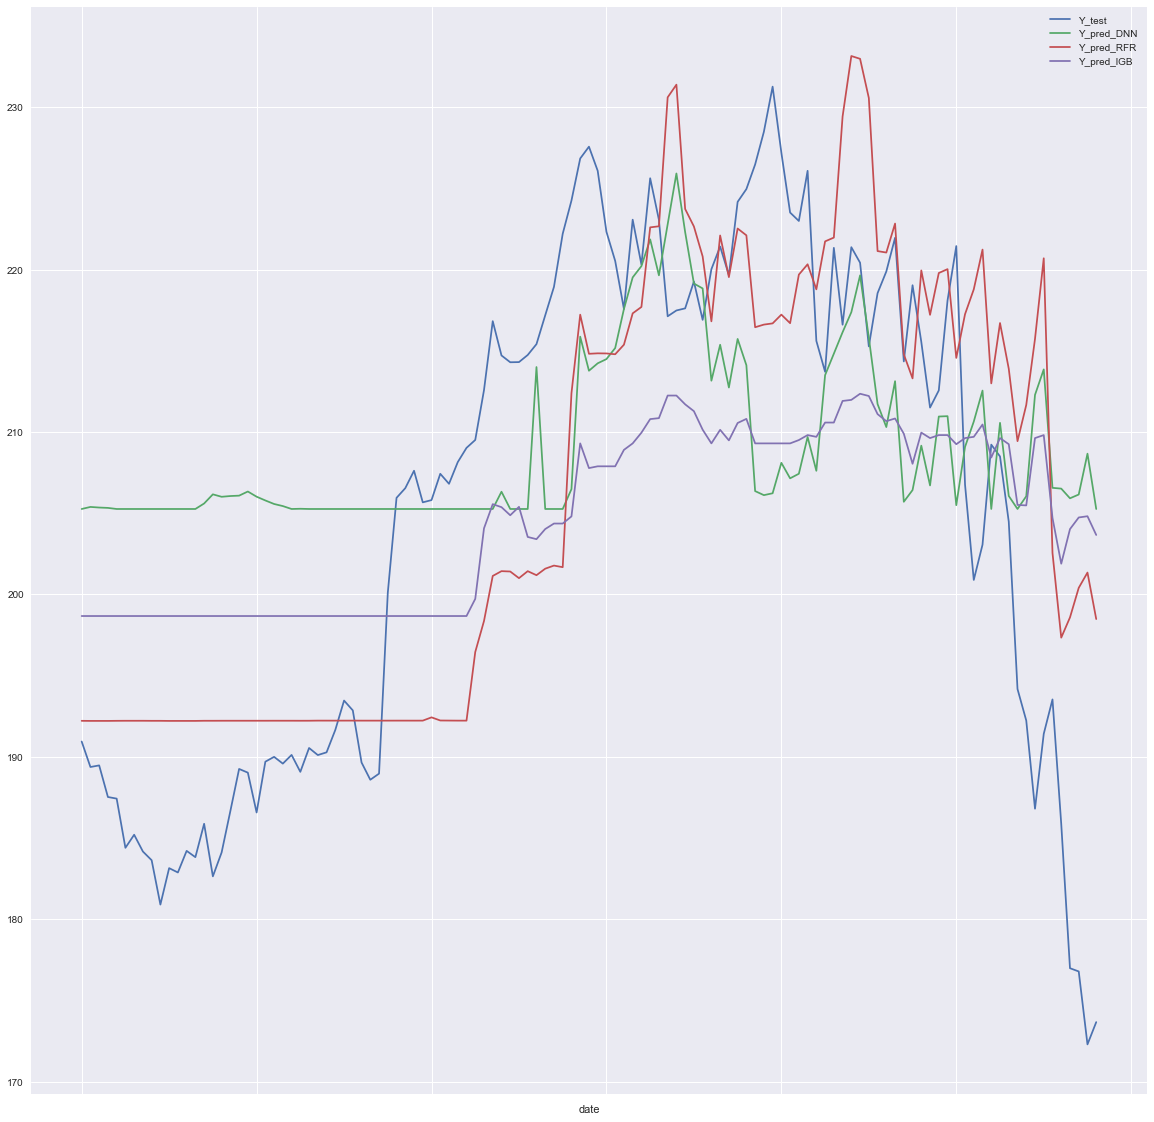

In [53]:
## First let's add the date column to predictions and test set to start plotting the data, 
## for let's convert them to their dataframes 

# prepare data to do inverse transformation
Y_test_df = pd.DataFrame(Y_test,columns=['Y_test']);
Y_pred_DNN_df = pd.DataFrame(Y_pred_DNN,columns=['Y_pred_DNN']);
Y_pred_RFR_df = pd.DataFrame(Y_pred_RFR,columns=['Y_pred_RFR']);
Y_pred_lGB_df = pd.DataFrame(Y_pred_lGB,columns=['Y_pred_lGB']);

display(Y_pred_RFR_df.head());

# Do the inverse transform
Y_pred_DNN = Y_Test_scaler.inverse_transform(Y_pred_DNN_df);
Y_pred_RFR = Y_Test_scaler.inverse_transform(Y_pred_RFR_df);
Y_pred_lGB = Y_Test_scaler.inverse_transform(Y_pred_lGB_df);
Y_test = Y_Test_scaler.inverse_transform(Y_test_df);


# convert data back and add date column

Y_test = pd.DataFrame(Y_test,columns=['Y_test']);
Y_pred_DNN = pd.DataFrame(Y_pred_DNN,columns=['Y_pred_DNN']);
Y_pred_RFR = pd.DataFrame(Y_pred_RFR,columns=['Y_pred_RFR']);
Y_pred_lGB = pd.DataFrame(Y_pred_lGB,columns=['Y_pred_lGB']);


# add the index of Test_set before copying it's date column over
Y_test.index = Test_set.index
Y_pred_DNN.index = Test_set.index;
Y_pred_RFR.index = Test_set.index;
Y_pred_lGB.index = Test_set.index;

# add the date column
Y_test['date'] = Test_set['date'];
Y_pred_DNN['date'] = Test_set['date'];
Y_pred_RFR['date'] = Test_set['date'];
Y_pred_lGB['date'] = Test_set['date'];


# merge all the dataframes
All_prediction_frames = [Y_test,Y_pred_DNN,Y_pred_RFR,Y_pred_lGB];
Merged_prediction_frames = reduce(lambda  left,right: pd.merge(left,right,on='date'), All_prediction_frames)

# plot the graph using merged dataframe
Merged_prediction_frames.set_index('date', inplace=True);

Merged_prediction_frames.plot(kind='line', grid=True,figsize=(20, 20));

#display(Merged_prediction_frames.head())

#display(Y_pred_RFR.head())
#display(Y_pred_DNN.info())

In [34]:
# The Score for Random Forest

Randomforest_score = r2_score(Y_test,Y_pred_RFR);
print(Randomforest_score);

0.5557443999104856


In [35]:
# The Score for Light GBM

lightgbm_score = r2_score(Y_test,Y_pred_lGB);
print(lightgbm_score);

0.4092034782882987


In [36]:
## The score for DNN model 
DNN_score = r2_score(Y_test,Y_pred_DNN);
print(DNN_score);

0.185805508153427


In [38]:
## The score of LSTM model
### r2 score doesnot work with LSTM data as it's 3D, so we will first need to convert it back to 2D to make a prediction

Y_pred_lstm = Y_pred_lstm.reshape(100,1);
Y_test_lstm = Y_test_lstm.reshape(100,1);

LSTM_score = r2_score(Y_test_lstm,Y_pred_lstm);

print(LSTM_score);

-0.0018092164899574659


In [ ]:
# Let's rescale these predictions and plot them against the actual values


In [ ]:
#Let's save this in the predictions folder for now.

np.savetxt("..\predictions\DNN_predictions.csv",Y_pred_DNN,fmt="%G", delimiter=",");
np.savetxt("..\predictions\LGB_predictions.csv",Y_pred_LGB,fmt="%G", delimiter=",");
np.savetxt("..\predictions\RFR_predictions.csv",Y_pred_RFR,fmt="%G", delimiter=",");
np.savetxt("..\predictions\LSTM_predictions.csv",Y_pred_lstm,fmt="%G", delimiter=",");